In [105]:
import json
import os
from collections import defaultdict
import traceback
import xml.etree.ElementTree as ET
from xml.dom import minidom
import argparse

import fitz
from fitz import Rect
from PIL import Image
import numpy as np
from tqdm import tqdm
import editdistance

from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [106]:
def convert_coords(cell_bbox, crop_bbox):
    x1 = cell_bbox[0]
    y1 = cell_bbox[1]
    x2 = cell_bbox[2]
    y2 = cell_bbox[3]
    x1_new = x1 - crop_bbox[0]
    y1_new = y1 - crop_bbox[1]  
    x2_new = x2 - crop_bbox[0]
    y2_new = y2 - crop_bbox[1]
    cell_bbox = [x1_new, y1_new, x2_new, y2_new]
    return cell_bbox

In [107]:
def get_row_col_cell(num_rows, num_columns, table_dict):
    row_dict = {key : [] for key in range(num_rows)}
    col_dict = {key : [] for key in range(num_columns)}
    for cell in table_dict['cells']:
        if len(cell['row_nums']) == 1:
            idx_row = cell['row_nums'][0]
            # idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            ori_bbox = [int(round(scale * elem)) for elem in ori_bbox]
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, crop_bbox)
            row_dict[idx_row].append([x1, y1, x2, y2])
            # col_dict[idx_col].append([x1, y1, x2, y2])
    for cell in table_dict['cells']:
        if len(cell['column_nums']) == 1:
            # idx_row = cell['row_nums'][0]
            idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            ori_bbox = [int(round(scale * elem)) for elem in ori_bbox]
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, crop_bbox)
            # row_dict[idx_row].append([x1, y1, x2, y2])
            col_dict[idx_col].append([x1, y1, x2, y2])
    return  row_dict, col_dict

In [108]:
def get_row_col_cell(num_rows, num_columns, table_dict):
    row_dict = {key : [] for key in range(num_rows)}
    col_dict = {key : [] for key in range(num_columns)}
    for cell in table_dict['cells']:
        if len(cell['row_nums']) == 1:
            idx_row = cell['row_nums'][0]
            # idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            ori_bbox = [int(round(scale * elem)) for elem in ori_bbox]
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, crop_bbox)
            row_dict[idx_row].append([x1, y1, x2, y2])
            # col_dict[idx_col].append([x1, y1, x2, y2])
    for cell in table_dict['cells']:
        if len(cell['column_nums']) == 1:
            # idx_row = cell['row_nums'][0]
            idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            ori_bbox = [int(round(scale * elem)) for elem in ori_bbox]
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, crop_bbox)
            # row_dict[idx_row].append([x1, y1, x2, y2])
            col_dict[idx_col].append([x1, y1, x2, y2])
    return  row_dict, col_dict

In [109]:
def create_document_page_image(doc, page_num, output_image_max_dim=1000):
    page = doc[page_num]
    page_width = page.rect[2]
    page_height = page.rect[3]
    
    if page_height > page_width:
        zoom = output_image_max_dim / page_height
        output_image_height = output_image_max_dim
        output_image_width = int(round(output_image_max_dim * page_width / page_height))
    else:
        zoom = output_image_max_dim / page_width
        output_image_width = output_image_max_dim
        output_image_height = int(round(output_image_max_dim * page_height / page_width))
        
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix = mat, alpha = False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    return img

In [110]:
def get_row_binary(row_bbox_final, image_crop):
    h,w,c = np.array(image_table_crop).shape
    row_image = np.zeros(shape = (h,w))
    row_1d = np.zeros(shape = (h,), dtype = np.uint8)

    for row_bbox in row_bbox_final:
        x1 = row_bbox[0]
        y1 = row_bbox[1]
        x2 = row_bbox[2]
        y2 = row_bbox[3]
        row_image[y1:y2, x1:x2] = 1
        row_1d[y1:y2] = 1
    return row_image, row_1d

def get_col_binary(col_bbox_final, image_crop):
    h,w,c = np.array(image_table_crop).shape
    col_image = np.zeros(shape = (h,w))
    col_1d = np.zeros(shape =(w,),dtype =  np.uint8)

    for col_bbox in col_bbox_final:
        x1 = col_bbox[0]
        y1 = col_bbox[1]
        x2 = col_bbox[2]
        y2 = col_bbox[3]
        col_image[y1:y2,x1:x2] = 1
        col_1d[x1:x2] = 1
    return col_image, col_1d

In [134]:
def get_row_bbox_final(row_dict, image_crop):
    row_bbox_final = []
    h,w,c = np.array(image_crop).shape
    # print(h,w,c)
    for row_element in row_dict:
        # print(row_element, row_dict[row_element])
        if len(row_dict[row_element]) == 0:
            continue
        row_element = np.array(row_dict[row_element])
        y1_min = np.min(row_element[:,1])+1
        y2_max = np.max(row_element[:,3])-1
        if abs(y2_max-y1_min) < 11:
            mid = (y2_max+y1_min)//2
            y1_min = mid-5
            y2_max = mid+5
        x1 = 0
        x2 = w
        row_bbox_final.append([x1, y1_min, x2, y2_max])
    return row_bbox_final

def get_col_bbox_final(col_dict, image_crop):
    col_bbox_final = []
    h,w,c = np.array(image_crop).shape
    for col_element in col_dict:
        if len(col_dict[col_element]) == 0:
            continue
        # print(col_element, col_dict[col_element])
        col_element = np.array(col_dict[col_element])
        x1_min = np.min(col_element[:,0])+1
        x2_max = np.max(col_element[:,2])-1
        if abs(x2_max-x1_min) < 8:
            mid = (x2_max+x1_min)//2
            x1_min = mid-4
            x2_max = mid+4
        # print(x1_min, x2_max)
        y1 = 0
        y2 = h
        col_bbox_final.append([x1_min, y1, x2_max, y2])
    return col_bbox_final

In [112]:
data_img_path = 'C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Structure_PASCAL_VOC/images/'
data_words_path = 'C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Table_Words_JSON/'
data_anotation_path = 'C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_PDF_Annotations_JSON/'

In [113]:
file_list =os.listdir('C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Structure_PASCAL_VOC/images/')

In [114]:
i = 1

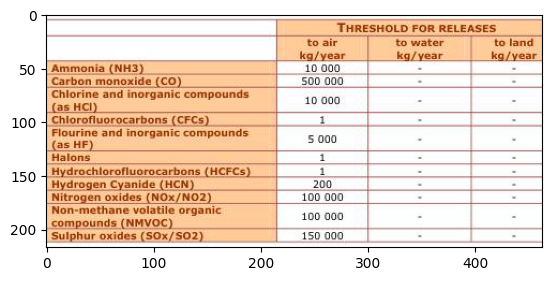

In [115]:
file_name_image = file_list[i]
file_name_root = file_list[i].split('.')[0]
file_name_words = file_name_root + '.json'  
file_name_anotation = file_name_root + '.json'
table_image_filepath = data_img_path + file_name_image
test_img = Image.open(table_image_filepath)
plt.imshow(test_img)
plt.show()

In [116]:
anotation_folder_path = 'C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_PDF_Annotations_JSON/'
anotation_file_list = os.listdir(anotation_folder_path) 

In [117]:
pdf_root_folder ="D:/ICDAR-2013-Table-Competition-Corrected (2)/ICDAR-2013-Table-Competition-Corrected/"

In [118]:
i = 2
anotation_sample = anotation_file_list[i]
anotation_sample_path = anotation_folder_path + anotation_sample
with open(anotation_sample_path, 'r') as f:
    annotations = json.load(f)

In [119]:
anotation_sample

'competition-dataset-eu_eu-003_tables.json'

In [120]:
pdf_folder , pdf_file_name ,_ = anotation_sample.split('_')
print(pdf_folder)
print(pdf_file_name)
pdf_file_path = pdf_root_folder + pdf_folder + '/' + pdf_file_name + '.pdf'
pdf_file_path

competition-dataset-eu
eu-003


'D:/ICDAR-2013-Table-Competition-Corrected (2)/ICDAR-2013-Table-Competition-Corrected/competition-dataset-eu/eu-003.pdf'

In [121]:
output_image_max_dim = 1000

In [130]:
data_frame = {}
final_output_folder = "/final_output"
if not os.path.exists(final_output_folder):
    os.makedirs(final_output_folder)
else :
    print("Folder already exists")

Folder already exists


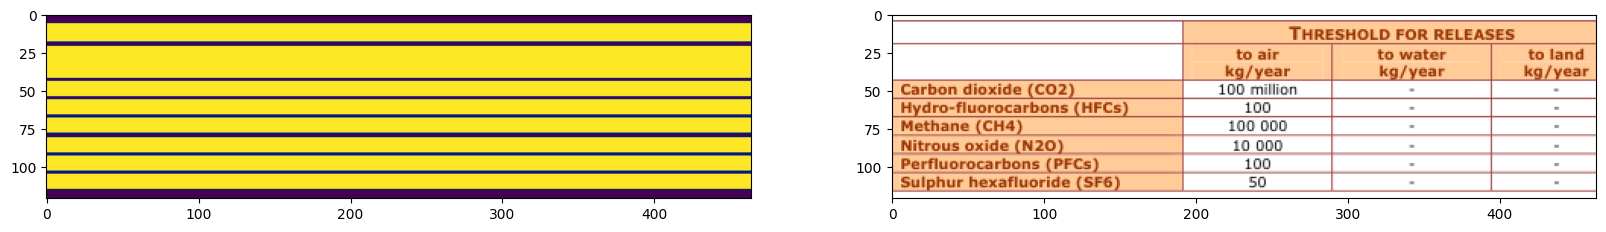

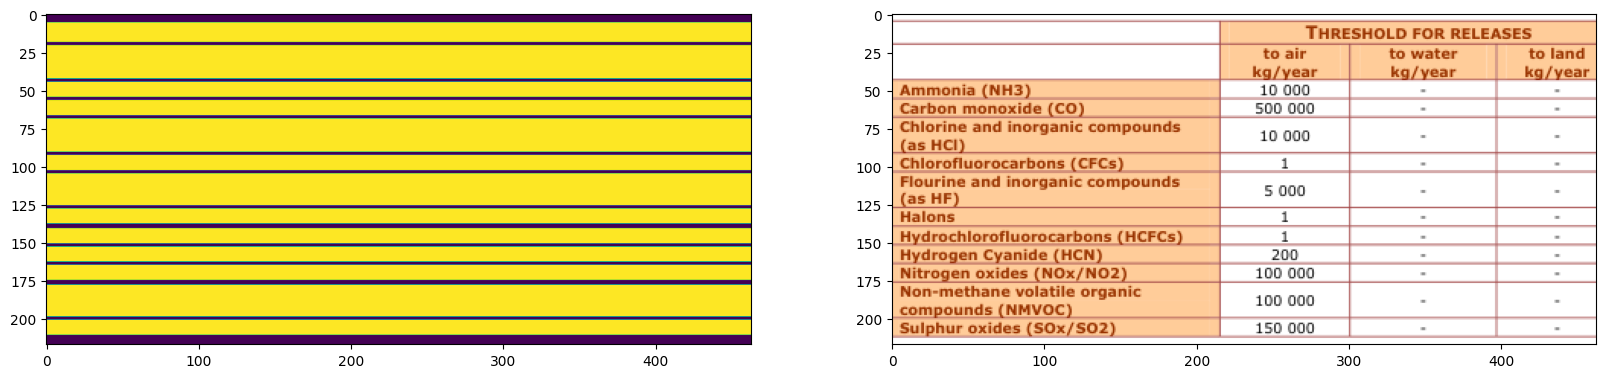

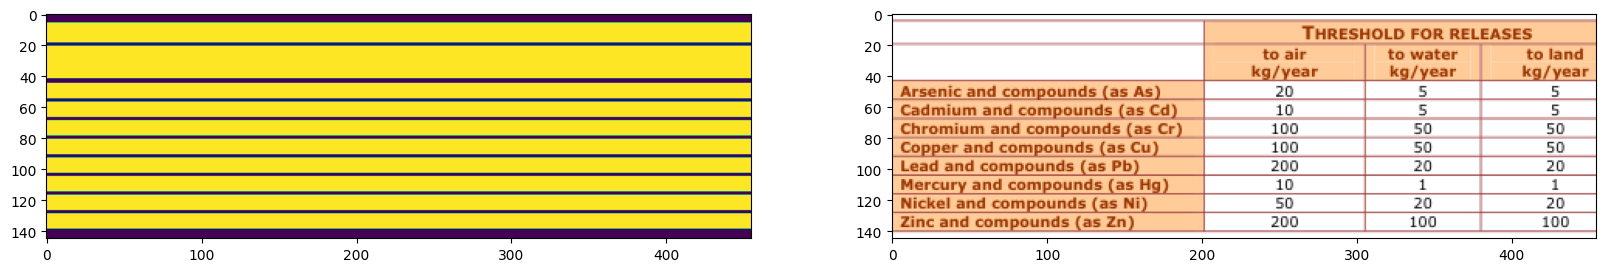

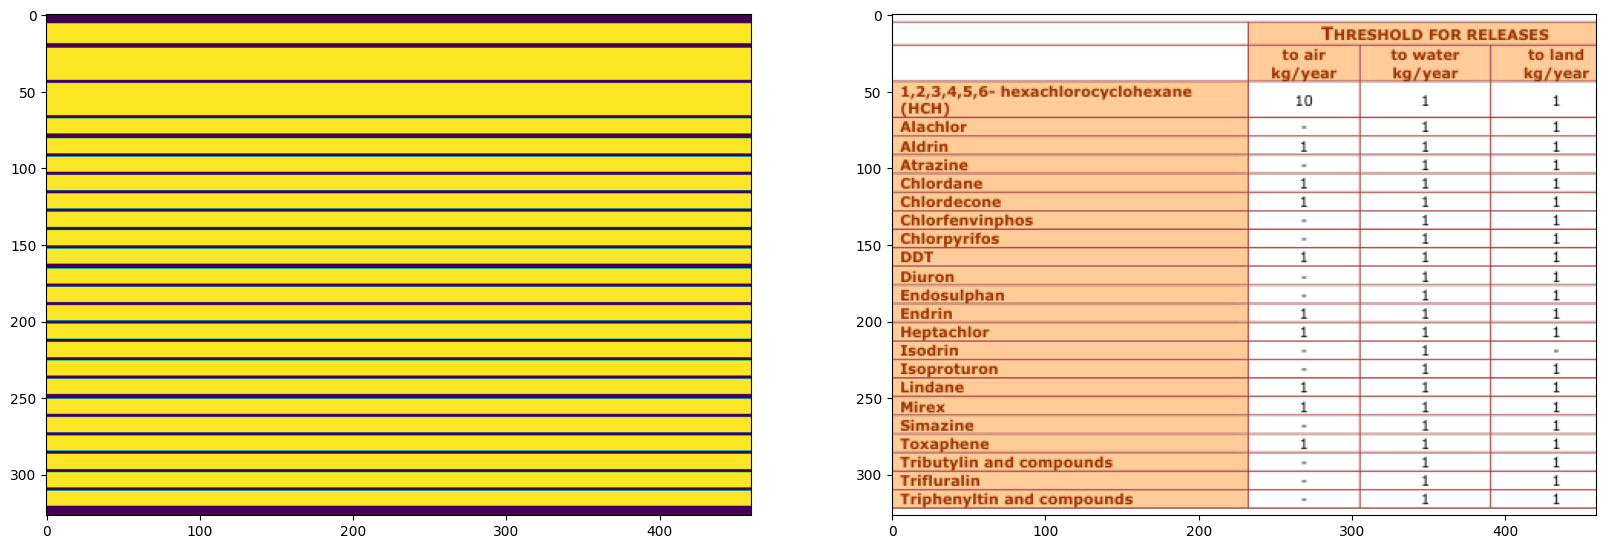

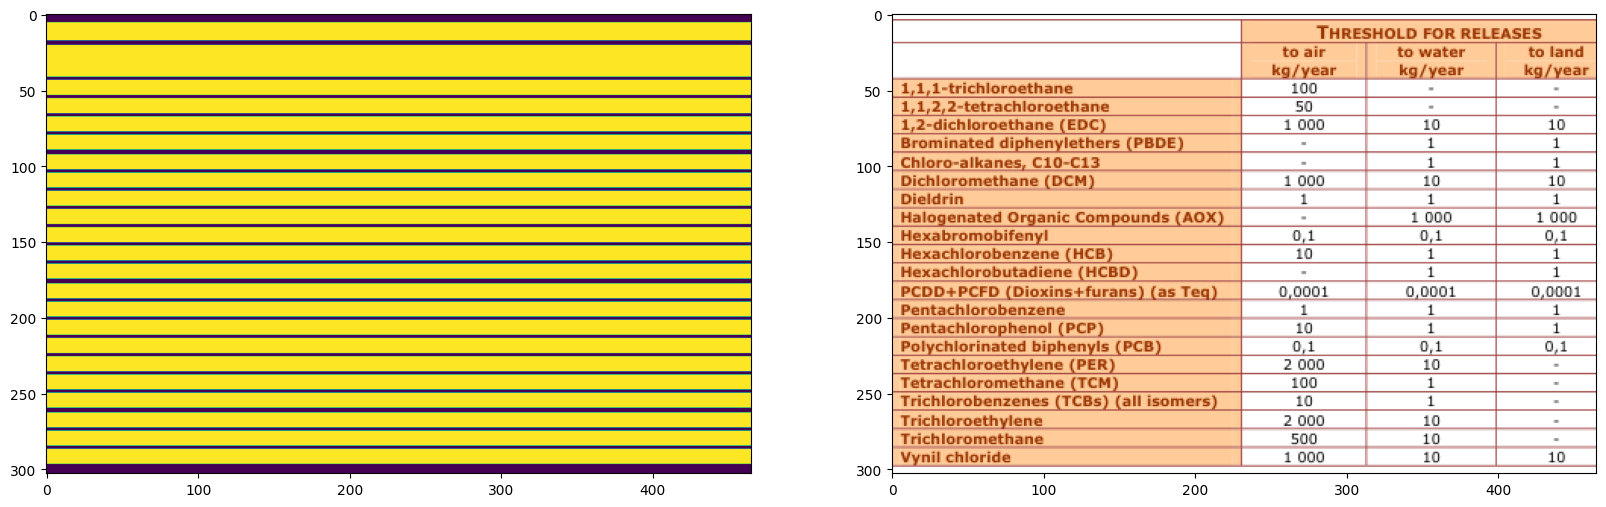

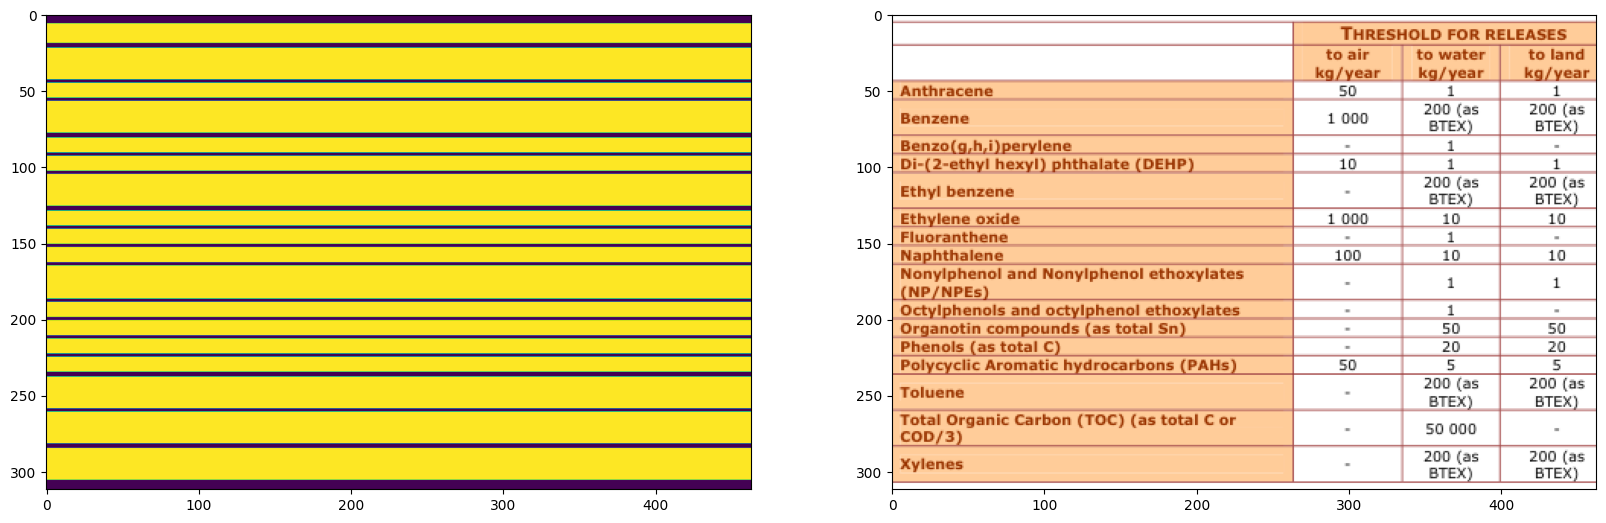

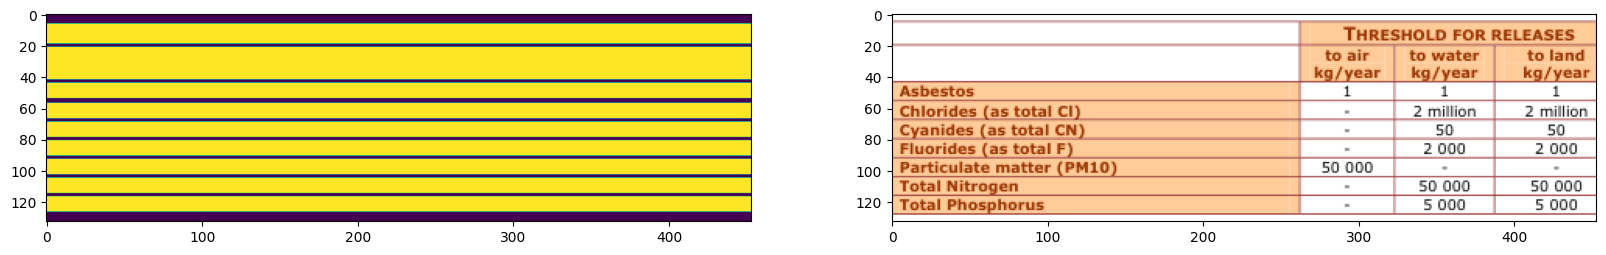

In [ ]:
anotation_file_list = os.listdir(anotation_folder_path) 
max_l = len(anotation_file_list)
for i in range(max_l):
    if i > 0:
        break
    anotation_sample = anotation_file_list[i]
    anotation_sample_path = anotation_folder_path + anotation_sample
    with open(anotation_sample_path, 'r') as f:
        annotations = json.load(f)
    pdf_folder , pdf_file_name ,_ = anotation_sample.split('_')
    # print(pdf_folder)
    # print(pdf_file_name)
    pdf_file_path = pdf_root_folder + pdf_folder + '/' + pdf_file_name + '.pdf'
    doc = fitz.open(pdf_file_path)
    num_table_per_image = len(annotations)
    for sub_i in range(num_table_per_image):
        table_dict = annotations[sub_i]
        page_num = table_dict['pdf_page_index']
        page_rect = list(doc[page_num].rect)
        scale = output_image_max_dim / max(page_rect)
        page_img = create_document_page_image(doc, page_num, output_image_max_dim=output_image_max_dim)
        page_img_np = np.array(page_img)

        # plt.imshow(page_img_np)
        # plt.show()

        table_num = table_dict['document_table_index']
        page_num = table_dict['pdf_page_index']
        page_rect = list(doc[page_num].rect)
        scale = output_image_max_dim / max(page_rect)
        table_bbox = table_dict['pdf_table_bbox']
        crop_bbox = [int(round(scale * elem)) for elem in table_bbox]
        padding = 5
        crop_bbox = [crop_bbox[0] - padding, crop_bbox[1] - padding, crop_bbox[2] + padding, crop_bbox[3] + padding]
        table_img = page_img.crop(crop_bbox)    
        table_img_np = np.array(table_img)
        # plt.imshow(table_img_np)
        # plt.show()
        num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
        num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
        row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
        image_table_crop = table_img_np.copy()
        row_final = get_row_bbox_final(row_dict, image_table_crop)
        col_final = get_col_bbox_final(col_dict, image_table_crop)
        row_image, row_1d = get_row_binary(row_final, image_table_crop)
        col_image, col_1d = get_col_binary(col_final, image_table_crop)    
        ###### Plotting ######
        # fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        # ax[0].imshow(row_image)
        # ax[1].imshow(image_table_crop)
        # ax[2].imshow(col_image)
        ##########################

        ###### save data ######
        

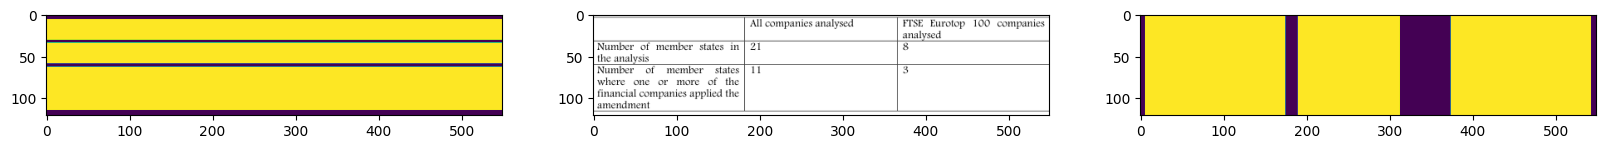

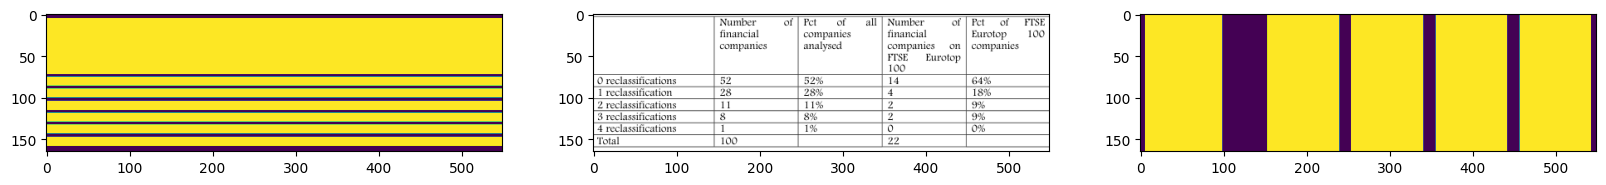

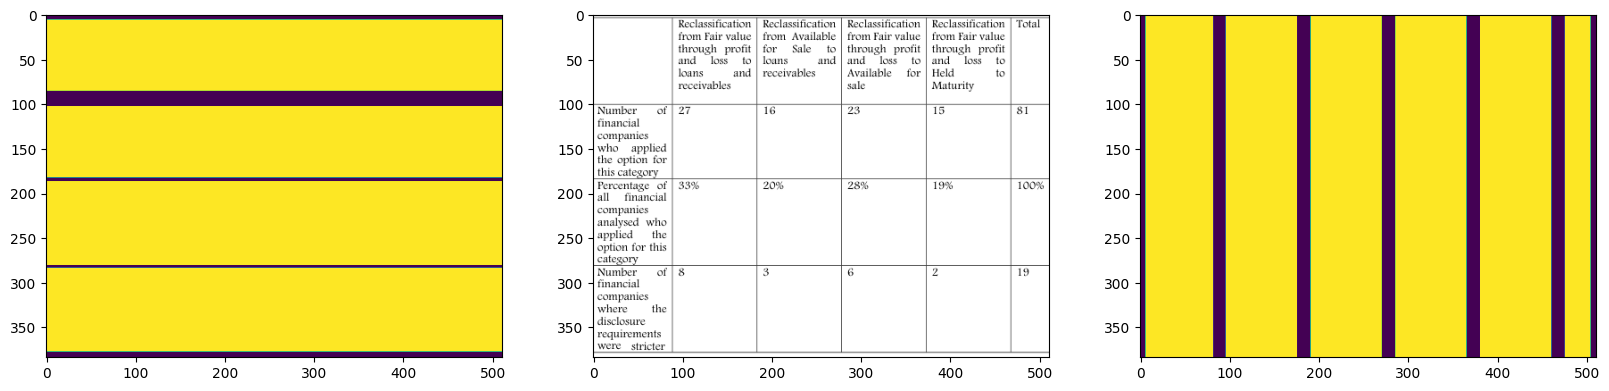

In [ ]:
# doc = fitz.open(pdf_file_path)
# num_table_per_image = len(annotations)
# for i in range(num_table_per_image):
#     if i >6:
#         break
#     table_dict = annotations[i]
#     page_num = table_dict['pdf_page_index']
#     page_rect = list(doc[page_num].rect)
#     scale = output_image_max_dim / max(page_rect)
#     page_img = create_document_page_image(doc, page_num, output_image_max_dim=output_image_max_dim)
#     page_img_np = np.array(page_img)

#     # plt.imshow(page_img_np)
#     # plt.show()

#     table_num = table_dict['document_table_index']
#     page_num = table_dict['pdf_page_index']
#     page_rect = list(doc[page_num].rect)
#     scale = output_image_max_dim / max(page_rect)
#     table_bbox = table_dict['pdf_table_bbox']
#     crop_bbox = [int(round(scale * elem)) for elem in table_bbox]
#     padding = 5
#     crop_bbox = [crop_bbox[0] - padding, crop_bbox[1] - padding, crop_bbox[2] + padding, crop_bbox[3] + padding]
#     table_img = page_img.crop(crop_bbox)    
#     table_img_np = np.array(table_img)
#     # plt.imshow(table_img_np)
#     # plt.show()
#     num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
#     num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
#     row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
#     image_table_crop = table_img_np.copy()
#     row_final = get_row_bbox_final(row_dict, image_table_crop)
#     col_final = get_col_bbox_final(col_dict, image_table_crop)
#     row_image, row_1d = get_row_binary(row_final, image_table_crop)
#     col_image, col_1d = get_col_binary(col_final, image_table_crop)    
#     # plt.imshow(table_image_copy)
#     # plt.show()
#     fig, ax = plt.subplots(1, 3, figsize=(20, 10))
#     ax[0].imshow(row_image)
#     ax[1].imshow(image_table_crop)
#     ax[2].imshow(col_image)

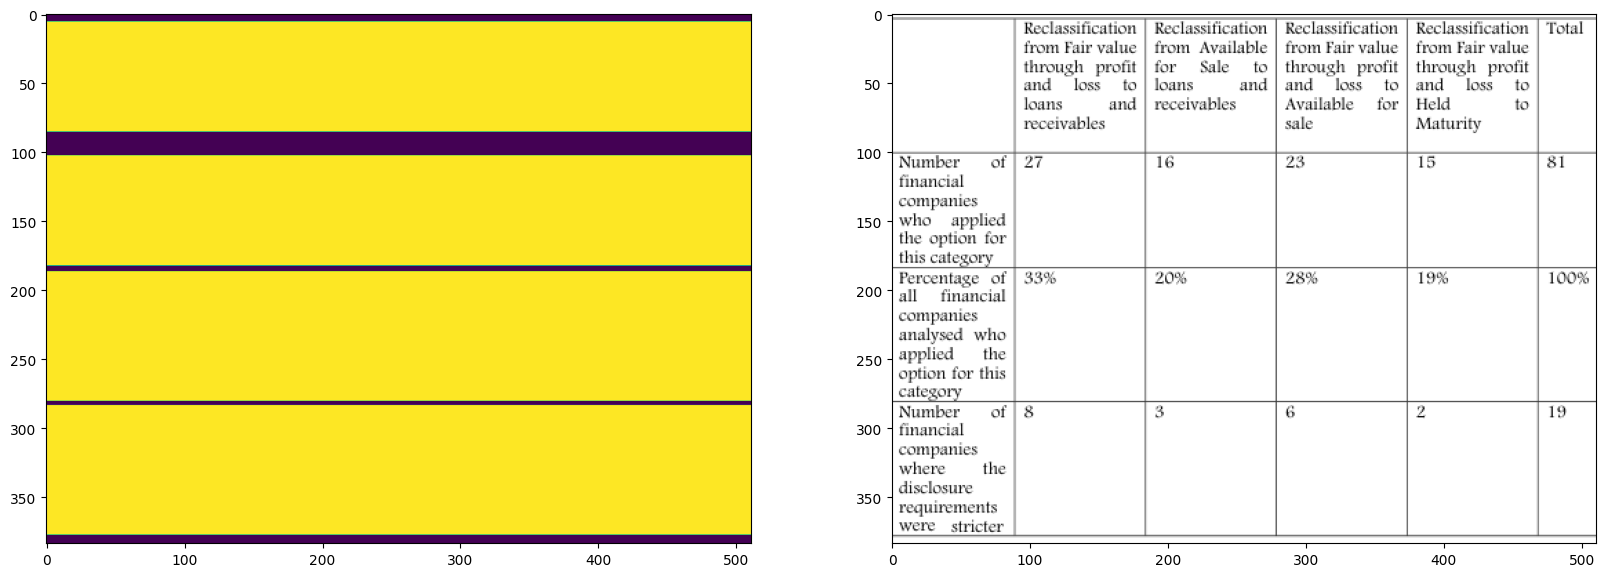

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(row_image)
ax[1].imshow(image_table_crop)

In [124]:
crop_bbox

[112, 527, 623, 911]

In [125]:
num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
print(num_rows, num_columns)

4 6
